In [217]:
###Import required packages
import numpy as np
import random
import time
import pandas as pd
from scikits.odes.ode import ode
from models import loss_biological, toy_model
from scipy.optimize import Bounds, minimize
from geneticalgorithm import geneticalgorithm as ga
from matplotlib import pyplot as plt
import seaborn as sns
import itertools

In [21]:
###Specify if data is to be saved to CSV
save_data = True

In [22]:
###Helper functions for name conversion
def arch_converter(A):
    if A == 'Dual Control':
        return ((0, 1, 0), (1, 0, 0))

    elif A == 'No Control':
        return ((0, 0, 1), (0, 0, 1))

    elif A == 'Downstream Activation':
        return ((0, 0, 1), (1, 0, 0))

    elif A == 'Upstream Repression':
        return ((0, 1, 0), (0, 0, 1))
    else: return 'Invalid Circuit'

def name_converter(A):
    if A == ((0, 1, 0), (1, 0, 0)):
        return 'Dual Control'

    elif A == ((0, 0, 1), (0, 0, 1)):
        return 'No Control'

    elif A == ((0, 0, 1), (1, 0, 0)):
        return 'Downstream Activation'

    elif A == ((0, 1, 0), (0, 0, 1)):
        return 'Upstream Repression'
    else: return 'Invalid Circuit'

def solve_point(architecture, param_values):
    t = np.linspace(0, 5E4, 100) 
    y0 = np.array([2290., 0., 0., 0., 0., 0.])
    extra_options = {'old_api': False, 'user_data': [architecture, param_values]}
    ode_solver = ode('cvode', toy_model, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2)
    return loss

def gen_ics(N): #Generate N random initial conditions
    #Set random seed
    np.random.seed(2022)
    ics = []
    for i in range(N):
        k1 = random.uniform(1E-7,1E-3)
        k2 = random.uniform(1E-7,1E-3)
        theta1 = random.uniform(0.001,10)
        theta2 = random.uniform(0.001,10)

        init_conds = [[2.,theta1, k1], [2., theta2, k2]]
        ics.append(init_conds)
    return ics

In [ ]:
###Random sampling - 1000 samples, in triplicate
replicate = 1
for num_samples in [1000, 1000, 1000]:
    overall_results = pd.DataFrame()
    overall_start_time = time.time()
    ics = gen_ics(num_samples)
    for A in ['Dual Control', 'Upstream Repression', 'Downstream Activation', 'No Control']:
        start_time = time.time()
        losses = []; k1_trace = []; k2_trace = []; n1_trace = []; n2_trace = []; theta1_trace = []; theta2_trace = []
        for j in range(len(ics)):
            init_conds = ics[j]
            [[new_n1,new_theta1, new_k1], [new_n2, new_theta2, new_k2]] = init_conds
            architecture = arch_converter(A)
            func = name_converter(architecture)
            loss = solve_point(architecture, init_conds)
            losses.append(loss)
            k1_trace.append(new_k1)
            k2_trace.append(new_k2)
            n1_trace.append(new_n1)
            n2_trace.append(new_n2)
            theta1_trace.append(new_theta1)
            theta2_trace.append(new_theta2)
        elapsed_time = time.time() - start_time
        results = pd.DataFrame({'circuit': func, 'num_samples': num_samples,'loss':losses,'k1_trace':k1_trace,'k2_trace':k2_trace,'n1_trace':n1_trace,'n2_trace':n2_trace,'theta1_trace':theta1_trace, 'theta2_trace':theta2_trace, 'time': elapsed_time, 'replicate':replicate})
        overall_results = pd.concat([results, overall_results])
    replicate = replicate + 1
    overall_elapsed = time.time() - overall_start_time
    overall_results['overall_time'] = [overall_elapsed for i in range(len(overall_results))]
    if save_data: 
        if replicate == 1: overall_results.to_csv('../data/toy_model_random_sampling_'+str(num_samples)+'samples.csv')
        else: overall_results.to_csv('../data/toy_model_random_sampling_'+str(num_samples)+'samples.csv', mode='a', header=False)

In [87]:
###Grid search - repeated 3 times for timing data only
architectures = [((0, 0, 1), (1, 0, 0)), ((0, 1, 0), (0, 0, 1)), ((0, 0, 1), (0, 0, 1)), ((0, 1, 0), (1, 0, 0))]
k1s = np.linspace(1E-7, 1E-3, 10)
k2s = np.linspace(1E-7, 1E-3, 10)
theta1s = np.linspace(0.001, 10, 10)
theta2s = np.linspace(0.001, 10, 10)
t = np.linspace(0, 5E4, 100) 
y0 = np.array([2290., 0., 0., 0., 0., 0.]) 

for i in range(3): #run in triplicate
    grid_search_results = pd.DataFrame()
    overall_start_time = time.time()
    for architecture in architectures:
        for k1 in k1s:
                for k2 in k2s:
                        for theta1 in theta1s:
                                for theta2 in theta2s:
                                    param_values = [[2., theta1, k1], [2., theta2, k2]]
                                    extra_options = {'old_api': False, 'user_data': [architecture, param_values]}
                                    ode_solver = ode('cvode', toy_model, **extra_options)
                                    solution = ode_solver.solve(t, y0)
                                    j1, j2 = solution.values.y[-1, -2:]
                                    j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2)
                                    test = pd.DataFrame({'index':[0], 'architecture':name_converter(architecture), 'theta1':theta1, 'theta2':theta2, 'k1':k1, 'k2':k2, 'loss':loss, 'replicate': i+1})
                                    grid_search_results = pd.concat([grid_search_results, test])
    elapsed_time = time.time() - overall_start_time
    grid_search_results['time'] = elapsed_time
    print('replicate', i, 'complete')
    if save_data: 
        if i!=0: grid_search_results.to_csv('../data/toy_model_landscapes_grid_search.csv', mode='a', header=False)
        else: grid_search_results.to_csv('../data/toy_model_landscapes_grid_search.csv')

replicate 0 complete
replicate 1 complete
replicate 2 complete


In [88]:
###Gradient-Based
num_replicates = 100

def ode_fun(x, function):
    k1, k2, theta1, theta2 = x
    t = np.linspace(0, 5E4, 100) 
    y0 = np.array([2290., 0., 0., 0., 0., 0.])
    architecture = arch_converter(function)
    param_values = [[2., theta1, k1], [2., theta2, k2]]
    extra_options = {'old_api': False, 'user_data': [architecture, param_values]} #'rtol':1E-3
    ode_solver = ode('cvode', toy_model, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2)
    row = [k1, k2, theta1, theta2, loss, j2, j2, str(solution.flag)]
    trace.loc[len(trace)] = row
    if (str(solution.flag) == 'StatusEnum.SUCCESS') and loss > 0.0: return loss
    else: return 1.E7

solutions = []
times = []
traces = []
archs = ['Dual Control', 'Upstream Repression', 'Downstream Activation', 'No Control']
for j in archs:
    for i in range(num_replicates):
        start_time = time.time()
        columns = ['k1', 'k2', 'theta1', 'theta2', 'loss', 'j1', 'j2', 'sol_flag']
        trace = pd.DataFrame(columns=columns)
        bounds = Bounds([1E-7, 1E-7, 0.001, 0.001], [0.001, 0.001, 10., 10.])

        function = j
        init_values = [np.random.uniform(1E-7, 1E-3), np.random.uniform(1E-7, 1E-3), np.random.uniform(0.001, 10.), np.random.uniform(0.001, 10.)]
        sol = minimize(ode_fun, init_values, args=(function), method='TNC', bounds=bounds) #, options={'gtol':1e-10, 'stepmx':1E-2}
        elapsed_time = time.time() - start_time
        times.append(elapsed_time)
        solutions.append(sol)
        traces.append(trace)
    print('Completed Architecture', j)

overall_data = pd.DataFrame()
archs = ['Dual Control' for i in range(int(len(times)/4))] + ['Upstream Repression' for i in range(int(len(times)/4))] + ['Downstream Activation' for i in range(int(len(times)/4))] + ['No Control' for i in range(int(len(times)/4))]
for i in range(len(times)):
    s = solutions[i]
    arch = archs[i]
    trace = traces[i]
    trace['architecture'] = archs[i]
    trace['time'] = times[i]
    trace['best_loss'] = solutions[i].fun
    trace['replicate'] = (i+1)%3
    overall_data = pd.concat([overall_data, trace])
if save_data: overall_data.to_csv('../data/toy_model_gradient_based.csv')

Completed Architecture Dual Control
Completed Architecture Upstream Repression
Completed Architecture Downstream Activation
Completed Architecture No Control


In [ ]:
###Genetic Algorithm
def f(X):
    A, k1, k2, theta1, theta2 = X
    t = np.linspace(0, 5E4, 100) 
    y0 = np.array([2290., 0., 0., 0., 0., 0.])
    architecture = arch_converter(A)
    param_values = [[2., theta1, k1], [2., theta2, k2]]
    extra_options = {'old_api': False, 'user_data': [architecture, param_values], 'rtol':1E-3}
    ode_solver = ode('cvode', toy_model, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2)
    row = [A, k1, k2, theta1, theta2, loss, j2, j2, str(solution.flag)]
    trace.loc[len(trace)] = row
    if (str(solution.flag) == 'StatusEnum.SUCCESS') and loss > 0.0: return loss
    else: return 1.E7
    
varbound=np.array([[1,4],[1E-7,1E-3],[1E-7,1E-3], [1E-3, 10], [1E-3, 10]])
vartype=np.array([['int'], ['real'],['real'],['real'],['real']])

algorithm_param = {'max_num_iteration': None,\
                   'population_size':100,\
                   'mutation_probability':0.1,\
                   'elit_ratio': 0.01,\
                   'crossover_probability': 0.5,\
                   'parents_portion': 0.3,\
                   'crossover_type':'uniform',\
                   'max_iteration_without_improv':None}

columns = ['arch', 'k1', 'k2', 'theta1', 'theta2', 'loss', 'j1', 'j2', 'sol_flag']

for i in range(3): #triplicate
    trace = pd.DataFrame(columns=columns)
    model=ga(function=f,dimension=5,variable_type_mixed=vartype,variable_boundaries=varbound, algorithm_parameters=algorithm_param)

    start_time = time.time()
    model.run()
    elapsed_time = time.time() - start_time
    trace['Computational Time'] = elapsed_time
    trace['replicate'] = i+1
    results = model.output_dict
    if save_data: 
        if i!=0: trace.to_csv('../data/toy_model_genetic_algorithm.csv', mode='a', header=False)
        else: trace.to_csv('../data/toy_model_genetic_algorithm.csv')

In [222]:
###Combine into a single visualization data frame for efficiency
visualization_data = pd.DataFrame({'Method':[], 'Computational Time':[], 'Computational Time STD':[], 'Best Loss':[], 'Best Loss STD':[],'Function Evaluations':[]})

#Random sampling
random_sampling = pd.read_csv('../data/toy_model_random_sampling_1000samples.csv')
times = []
losses = []
for i in range(3):
    rand = random_sampling.loc[random_sampling.replicate == i+1]
    times.append(rand.overall_time.mean())
    losses.append(rand.loss.min())
row = pd.DataFrame({'Method': ['Naive Approach'], 'Computational Time': [np.mean(times)], 'Computational Time STD':[np.std(times)], 'Best Loss': [np.mean(losses)], 'Best Loss STD': [np.std(losses)],'Function Evaluations': [4000]})
visualization_data = pd.concat([visualization_data, row])

#Grid search
grid_search = pd.read_csv('../data/toy_model_landscapes_grid_search.csv')
times = []
losses = []
for i in range(3):
    gs = grid_search.loc[grid_search.replicate == i+1]
    times.append(gs.time.mean())
    losses.append(gs.loss.min())
row = pd.DataFrame({'Method': ['Exhaustive Search'], 'Computational Time': [np.mean(times)], 'Computational Time STD':[np.std(times)], 'Best Loss': [np.mean(losses)], 'Best Loss STD': [np.std(losses)],'Function Evaluations': [40000]})
visualization_data = pd.concat([visualization_data, row])

#Gradient-Based
# gradient_based = pd.read_csv('../data/toy_model_gradient_based.csv')
# nc = gradient_based.loc[gradient_based.architecture == 'No Control']
# ur = gradient_based.loc[gradient_based.architecture == 'Upstream Repression']
# da = gradient_based.loc[gradient_based.architecture == 'Downstream Activation']
# dc = gradient_based.loc[gradient_based.architecture == 'Dual Control']

# times = []
# losses = []
# for i in range(100):
#     time = 0.
#     nc_time = nc.loc[nc.time == nc.time.unique()[i]]
#     best_loss = nc_time.loss.min()
#     time += nc_time.time.mean()

#     ur_time = ur.loc[ur.time == ur.time.unique()[i]]
#     if ur_time.loss.min() < best_loss:
#         best_loss = ur_time.loss.min()
#     time += ur_time.time.mean()

#     da_time = da.loc[da.time == da.time.unique()[i]]
#     if da_time.loss.min() < best_loss:
#         best_loss = da_time.loss.min()
#     time += da_time.time.mean()

#     dc_time = dc.loc[dc.time == dc.time.unique()[i]]
#     if dc_time.loss.min() < best_loss:
#         best_loss = dc_time.loss.min()
#     time += dc_time.time.mean()

#     times.append(time)
#     losses.append(best_loss)
# row = pd.DataFrame({'Method': ['Gradient-Based'], 'Computational Time': [np.mean(times)], 'Computational Time STD':[np.std(times)], 'Best Loss': [np.mean(losses)], 'Best Loss STD': [np.std(losses)],'Function Evaluations': [np.nan]})
# visualization_data = pd.concat([visualization_data, row])

gradient_based = pd.read_csv('../data/toy_model_gradient_based.csv')
gradient_based['Architecture'] = [list(zip(np.arange(400), itertools.cycle(['Dual Control', 'Upstream Repression', 'Downstream Activation', 'No Control'])))[i][1] for i in range(400)]

#Split into 100 experiments
start = 0
best_losses = []
times = []
fevs = []
for j in range(100):
    df = gradient_based.iloc[start:start+4]
    start += 4

    best_losses.append(df['Best Loss'].min())
    times.append(df['Computational Time'].sum())
    fevs.append(df['Function Evaluations'].sum())
row = pd.DataFrame({'Method': ['Gradient-Based'], 'Computational Time': [np.mean(times)], 'Computational Time STD':[np.std(times)], 'Best Loss': [np.mean(best_losses)], 'Best Loss STD':[np.std(best_losses)], 'Function Evaluations': [np.mean(fevs)]})
visualization_data = pd.concat([visualization_data, row])


#Genetic Algorithm
genetic_alg = pd.read_csv('../data/toy_model_genetic_algorithm.csv')
times = []
losses = []
for i in range(3):
    ga = genetic_alg.loc[genetic_alg.replicate == i+1]
    ga = ga.loc[ga.loss > 0]
    times.append(ga['Computational Time'].mean())
    losses.append(ga.loss.min())
row = pd.DataFrame({'Method': ['Global Optimization'], 'Computational Time': [np.mean(times)], 'Computational Time STD':[np.std(times)], 'Best Loss': [np.mean(losses)], 'Best Loss STD': [np.std(losses)],'Function Evaluations': [100000]})
visualization_data = pd.concat([visualization_data, row])

#BayesOpt
bayes_opt = pd.read_csv('../data/toy_model_background.csv')

with open('../method_tuning/bayesopt_timing_multiarch.txt') as f:
    lines = f.readlines()
total_times = []
rates = []
for l in lines:
    if l[:3] == '100':
        total_times.append(l.split('[')[1].split('<')[0])
        rates.append(l.split('[')[1].split(', ')[1].split('t')[0])
rates = [float(rates[i].split('s')[0]) for i in range(len(rates))]

total_times_s = []
for i in range(len(total_times)):
    if len(total_times[i]) <= 5:
        total_times_s.append(60*float(total_times[i].split(':')[0]) + float(total_times[i].split(':')[1]))
    else: total_times_s.append(60*60*float(total_times[i].split(':')[0]) + 60*float(total_times[i].split(':')[1]) + float(total_times[i].split(':')[2]))

multi_parsed = pd.DataFrame({'Model':'Toy', 'Rates':rates, 'Computational Time': total_times_s}).reset_index()
bo_multi = pd.merge(multi_parsed, bayes_opt, on='index')

times = []
losses = []
for i in range(100):
    bo = bo_multi.loc[bo_multi['index']==i]
    times.append(bo['Computational Time'].mean())
    losses.append(bo['Loss'].min())
row = pd.DataFrame({'Method': ['Bayesian Optimization'], 'Computational Time': [np.mean(times)], 'Computational Time STD':[np.std(times)], 'Best Loss': [np.mean(losses)], 'Best Loss STD': [np.std(losses)],'Function Evaluations': [100000]})
visualization_data = pd.concat([visualization_data, row])

visualization_data

,Method,Computational Time,Computational Time STD,Best Loss,Best Loss STD,Function Evaluations
0,Naive Approach,168.894608,2.427257,0.064253,0.000695,4000.0
0,Exhaustive Search,1780.748056,105.316168,0.065600,0.000000,40000.0
0,Gradient-Based,64.431016,284.950932,0.073110,0.018503,766.9
0,Global Optimization,1627.165643,226.825220,0.054322,0.006667,100000.0
0,Bayesian Optimization,27.050000,0.887412,0.068492,0.004210,100000.0


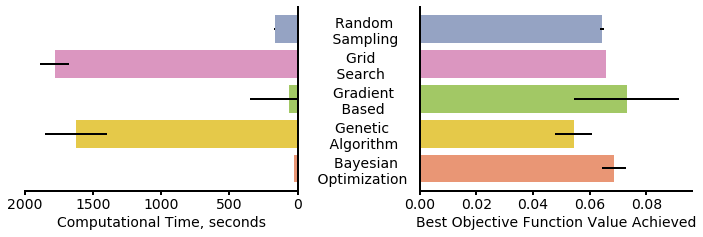

In [223]:
###FIGURE: Benchmarking results
###Color palette
palette = sns.color_palette("Set2")[2:6]
palette.append(sns.color_palette("Set2")[1])

fig, axs = plt.subplots(1,2,figsize=(10, 3.4))
ax = axs[0]
plot = sns.barplot(data=visualization_data, x='Computational Time', y='Method', hue='Method', palette=palette, ax=ax, dodge=False)
ax.hlines([0, 1, 2, 3, 4], [visualization_data['Computational Time'] - visualization_data['Computational Time STD']], [visualization_data['Computational Time'] + visualization_data['Computational Time STD']],  linewidth=2)

plot.set(yticklabels=[])
plot.legend_.remove()
ax.set_xlim([2000, 0])
ax.tick_params(axis='x', labelsize=14)
for axis in ['top','left','right']:
    ax.spines[axis].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.tick_params(width=2)
ax.set_ylabel('')
ax.set_xlabel('Computational Time, seconds', fontsize =14)
ax.set_yticks([])

ax = axs[1]
plot = sns.barplot(data=visualization_data, x='Best Loss', y='Method', hue='Method', palette=palette, ax=ax, dodge=False)
ax.hlines([0, 1, 2, 3, 4], [visualization_data['Best Loss'] - visualization_data['Best Loss STD']], [visualization_data['Best Loss'] + visualization_data['Best Loss STD']],  linewidth=2)

plot.set(yticklabels=['Random     \n Sampling    ','Grid         \n Search       ', 'Gradient     \n Based       ', 'Genetic      \n Algorithm    ', 'Bayesian    \n Optimization  '])
plot.legend_.remove()
ax.tick_params(axis='y', labelsize=14, length=0)
ax.tick_params(axis='x', labelsize=14)
for axis in ['top','left','right']:
    ax.spines[axis].set_linewidth(0)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

ax.tick_params(width=2)
ax.set_ylabel('')
ax.set_xlabel('Best Objective Function Value Achieved', fontsize =14)
plt.tight_layout()

fig.savefig('../figs/toy_model_benchmarking.png', dpi=500, bbox_inches='tight', pad_inches=0.)